In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.models import load_model,Model
import random
import math
import threading
import time

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
import copy
x_tmp = copy.deepcopy(x_test[0])

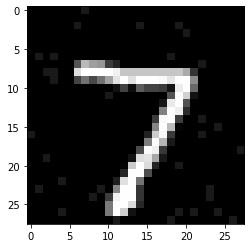

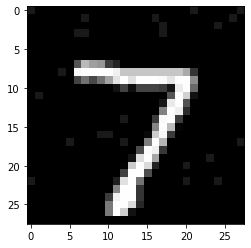

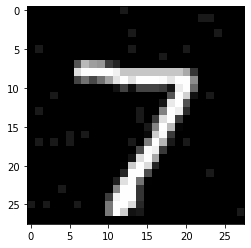

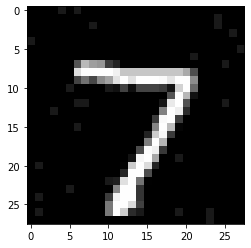

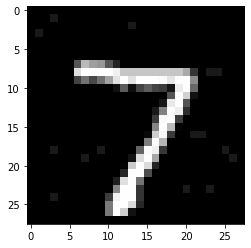

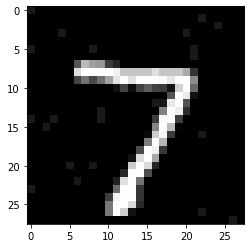

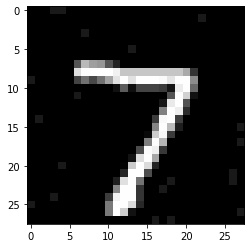

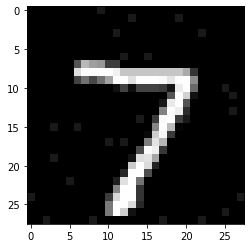

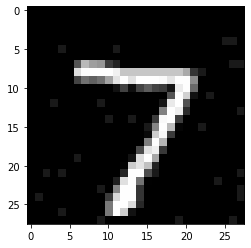

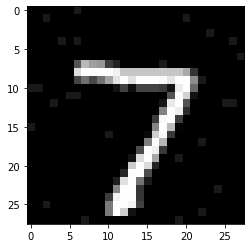

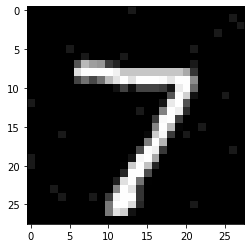

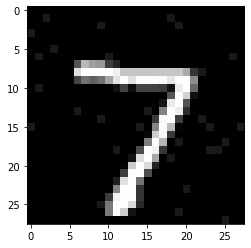

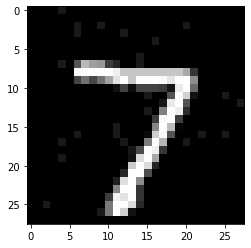

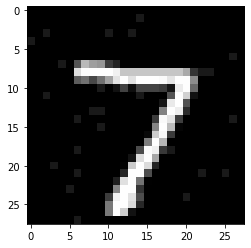

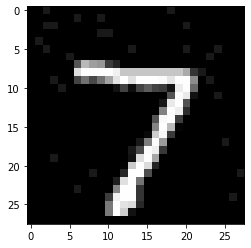

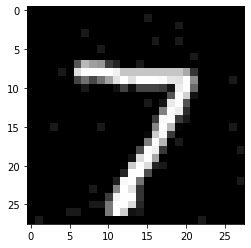

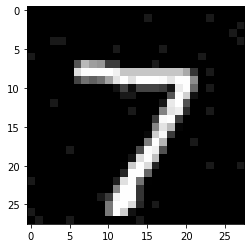

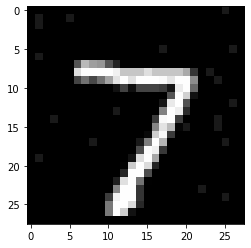

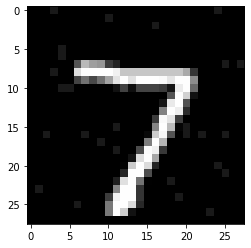

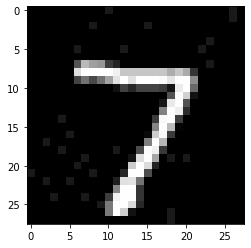

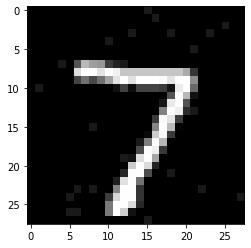

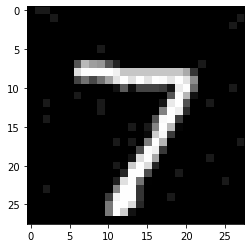

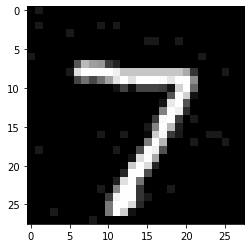

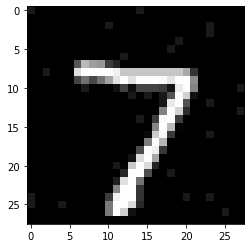

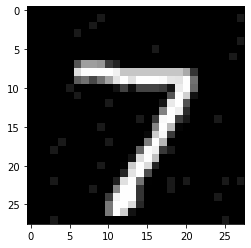

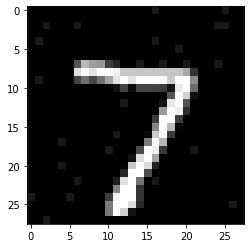

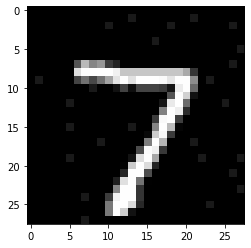

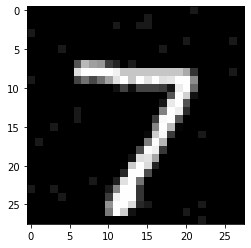

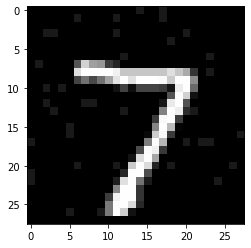

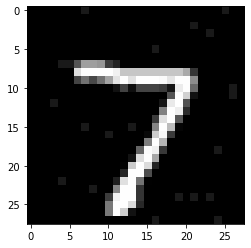

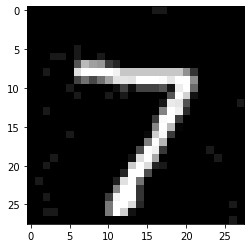

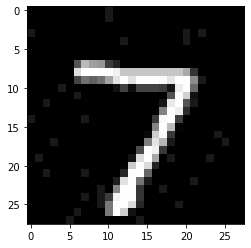

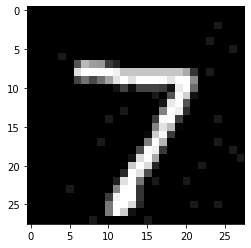

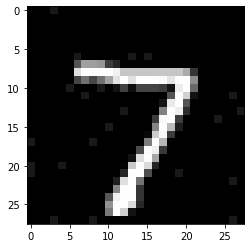

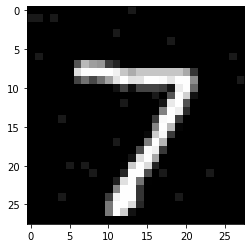

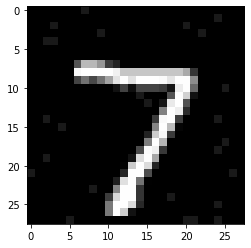

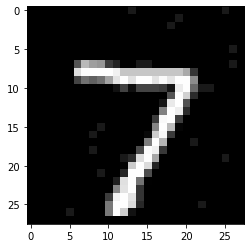

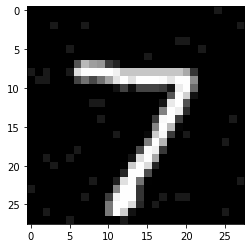

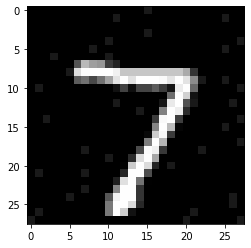

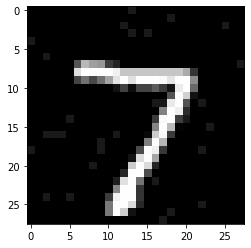

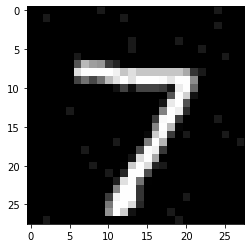

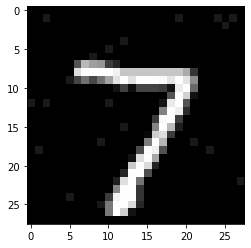

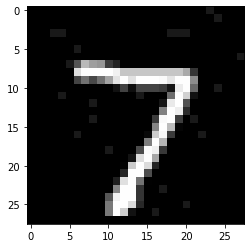

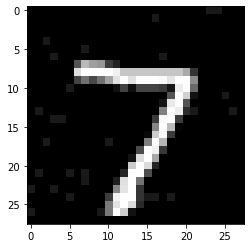

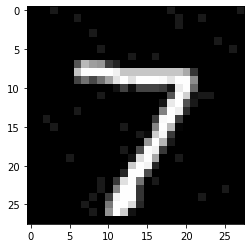

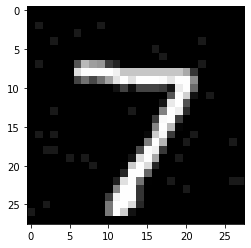

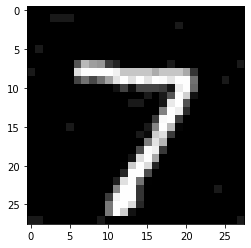

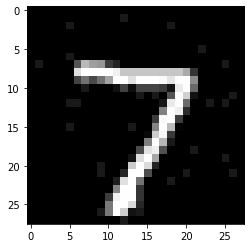

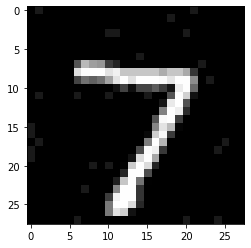

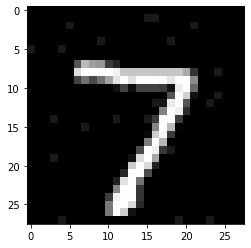

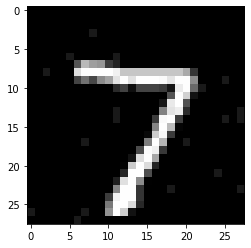

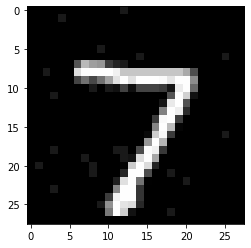

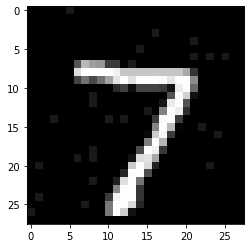

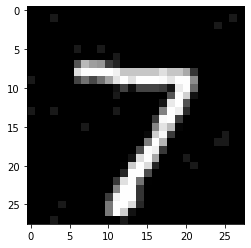

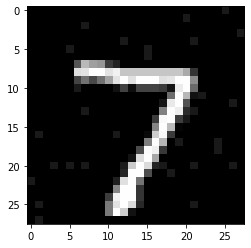

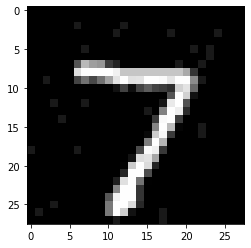

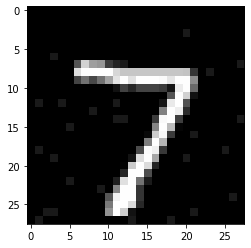

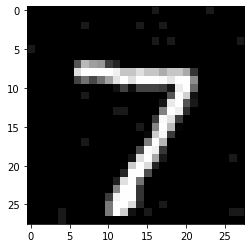

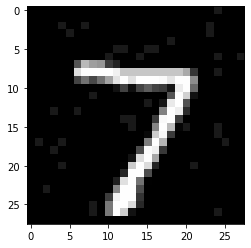

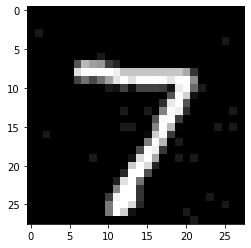

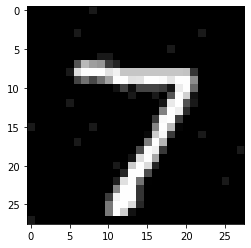

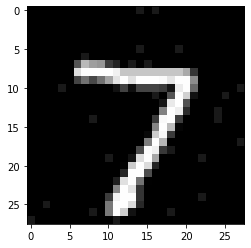

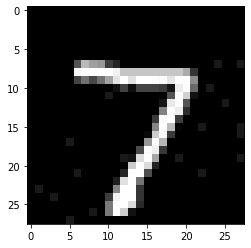

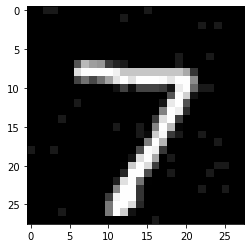

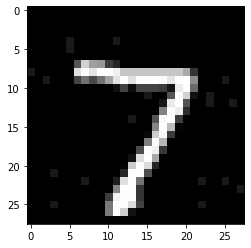

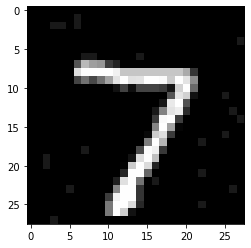

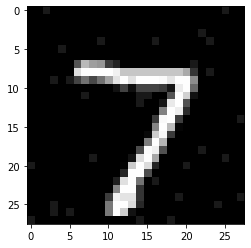

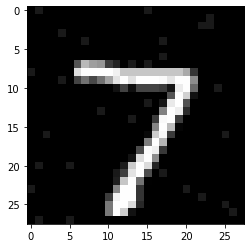

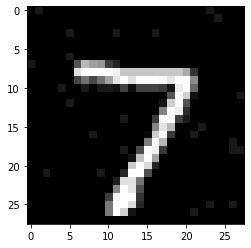

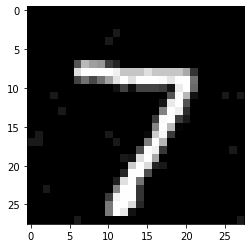

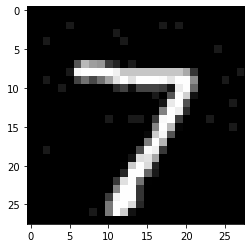

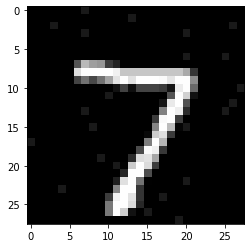

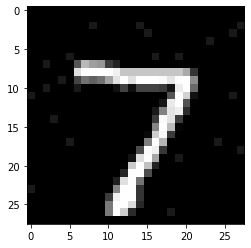

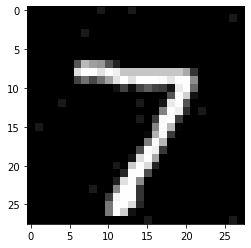

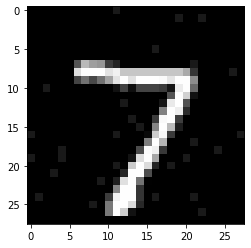

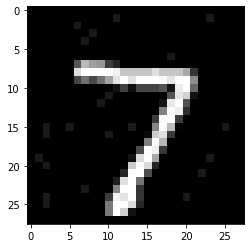

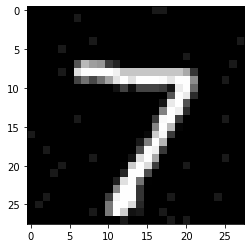

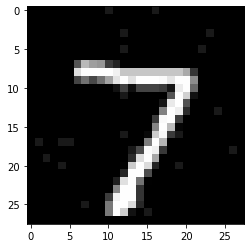

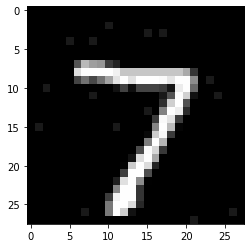

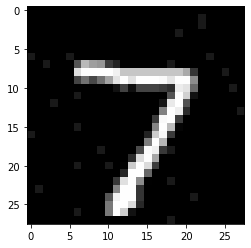

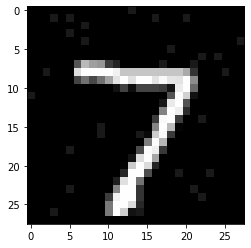

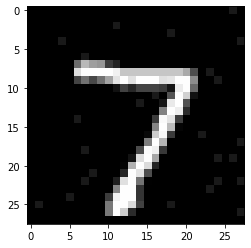

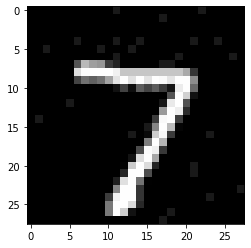

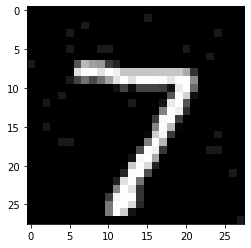

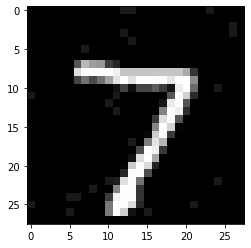

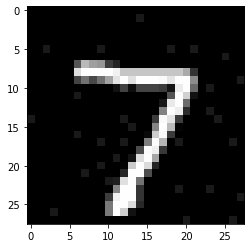

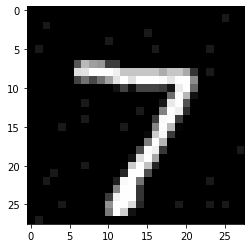

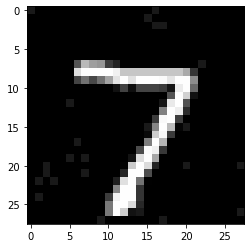

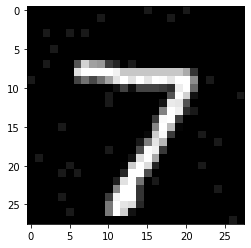

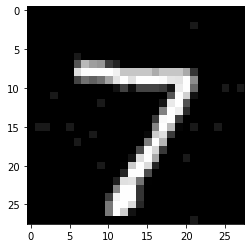

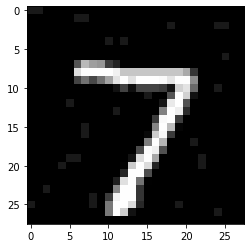

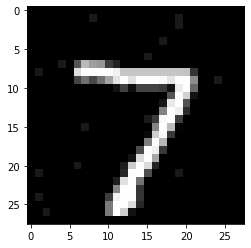

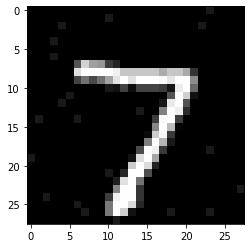

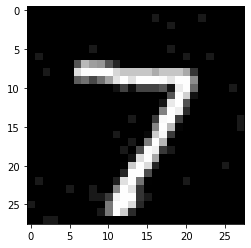

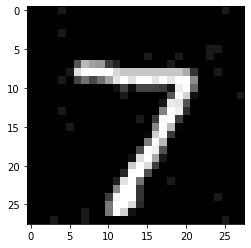

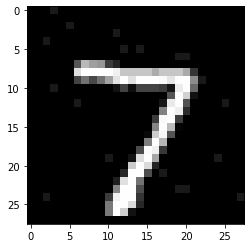

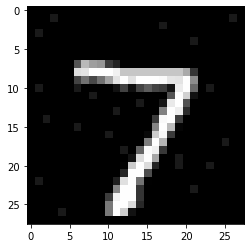

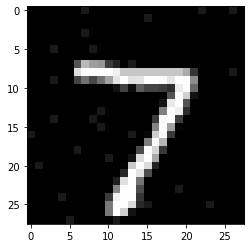

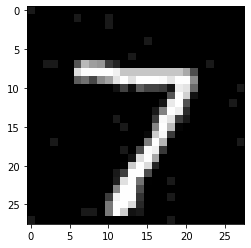

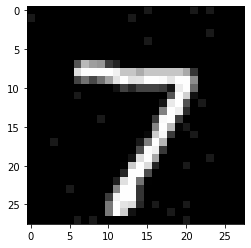

In [4]:
#产生扰动种群
x_des = []
for r in range(100):
    for i in range(28):
        for j in range(28):
            x= random.randint(0,10000)/10000
            if x <= 0.1:
                u = x_tmp[i,j] # 期望值μ
                sig = math.sqrt(0.2) # 标准差δ
                x_ = random.uniform(u - 3*sig, u + 3*sig)
                y_sig = np.exp(-(x_ - u) ** 2 /(2* sig **2))/(math.sqrt(2*math.pi)*sig)
                y_= random.randint(0,10000)/10000
                if y_ <= y_sig:
                    if x_test[0][i,j] <= 127:
                        x_tmp[i,j] += 255*0.1
                    elif x_test[0][i,j] > 127 and x_test[0][i,j] < 229:
                        y = random.randint(0,10000)/10000
                        if y <= 0.5:
                            x_tmp[i,j] += 255*0.1
                        else:
                            x_tmp[i,j] -= 255*0.1
                    elif x_test[0][i,j] >= 229:
                        x_tmp[i,j] -= 255*0.1
    x_t = x_tmp/255-x_test[0]/255
    #x_des.append(np.array (x_t.reshape(1,784)))
    x_des.append(np.array(x_t.reshape(1,784)))
    plt.imshow(x_tmp,cmap='gray')
    plt.show()
    x_tmp = copy.deepcopy(x_test[0])

In [5]:
x_train = x_train.reshape(60000,784)    # 将图片摊平，变成向量

In [6]:
x_test = x_test.reshape(10000,784)     # 对测试集进行同样的处理

In [7]:
x_train = x_train / 255
x_test = x_test / 255 

In [8]:
model = load_model('mnist_model.h5')

In [9]:
def Func(x):
    x_F = x[:]+x_test[0]
    result=model.predict(x_F.reshape(1,784))
    return result[0][7]

In [10]:
def Dis(x):   # 扰动值
    res = 0
    for i in range(784):
        l = x[i]
        res += l**2
    return res

In [12]:
# 攻击模块
class Atk(threading.Thread):

    def __init__(self,cond,name):
        #threading.Thread.__init__(self)
        super(Atk, self).__init__()
        self.cond = cond
        self.name = name

    def run(self):
        self.cond.acquire()
        print(self.name)
        global F
        global D
        global BEST_X
        global GENERATION
        global best
        while GENERATION < MAX_GENERATION:
        #while Func(BEST_X) >= 0.35 or Dis(BEST_X) >= 6.5:
        #for t in range(5):
            #print(Func(BEST_X))
            DB = Dis(BEST_X)    # 存储上一代的扰动程度
            # 变异
            for i in range(N):
                r = np.random.randint(1, N, 2)
                V[i, :] = BEST_X + SIGMA * (X[r[0], :] - X[r[1], :])
                for j in range(784):
                    if V[i, j] > 1:
                        #print(V[i, j])
                        V[i, j] = 1-(V[i, j]-1)
                        #print(V[i, j])
                    elif V[i, j] <= 1:
                        if V[i, j] + x_test[0][j] > 1:
                            # V +t = 1-(V+t-1)
                            V[i, j] = 1-(V[i, j]+2*x_test[0][j]-1)
                            #print(V[i, j])
                        elif V[i, j] + x_test[0][j] < 0:
                            V[i, j] = -x_test[0][j]
            # print(V)
            # 交叉操作
            for i in range(N):
                jRand = np.floor(np.random.random() * L)
                for j in range(L):
                    # 至少有一个分量对U[i,j]作出了贡献
                    # CR调小 有利于往BEST_X的方向进化
                    if np.random.random() > CR or j == jRand:
                        U[i, j] = X[i, j]
                    else:
                        U[i, j] = V[i, j]
                    #if np.random.random() < CR or j == jRand:
                        #U[i, j] = V[i, j]
                    #else:
                        #U[i, j] = X[i, j]
            # 计算适应度值+选择操作
            for i in range(N):
                FITS[i] = Func(X[i])
                FITS_U[i] = Func(U[i])
                DIS[i] = Dis(X[i])
                DIS_U[i] = Dis(U[i])
                
                D_ = DIS_U[i] - DB
                # 变异的种子表现更好
                if FITS[i] >= FITS_U[i] and D_ < 0.1:
                    X[i, :] = U[i, :]
                    FITS[i] = FITS_U[i]
                    if FITS_U[i] < Func(BEST_X) and D_ < 0.1:
                        BEST_X = U[i, :]
            GENERATION += 1
            
            print("最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X),"代数：",GENERATION)
            if Func(BEST_X) < Func(best) and Dis(BEST_X) < Dis(best):   # 保存最好的数值
                best[:] = BEST_X[:]
            
            if Func(BEST_X) <= F:
                print("resume")
                if D < 7.5:
                    D += 0.4 
                self.cond.notify()  # 唤醒一个挂起的线程
                self.cond.wait()
        self.cond.release()


# 恢复模块
class Re(threading.Thread):

    def __init__(self,cond,name):
        #threading.Thread.__init__(self)
        super(Re, self).__init__()
        self.cond = cond
        self.name = name

    def run(self):
        #time.sleep(1)
        self.cond.acquire()
        self.cond.wait()
        #print(self.name)
        global F
        global D
        global BEST_X
        global GENERATION
        global best
        while GENERATION < MAX_GENERATION:
        #while Func(BEST_X) >= 0.35 or Dis(BEST_X) >= 6.5:
        #for t in range(5):
            #print(Func(BEST_X))
            FB = Func(BEST_X)    # 存储上一代的置信度
            # 变异
            for i in range(N):
                r = np.random.randint(1, N, 2)
                V[i, :] = BEST_X + SIGMA * (X[r[0], :] - X[r[1], :])
                for j in range(784):
                    if V[i, j] > 1:
                        #print(V[i, j])
                        V[i, j] = 1-(V[i, j]-1)
                        #print(V[i, j])
                    elif V[i, j] <= 1:
                        if V[i, j] + x_test[0][j] > 1:
                            # V +t = 1-(V+t-1)
                            V[i, j] = 1-(V[i, j]+2*x_test[0][j]-1)
                            #print(V[i, j])
                        elif V[i, j] + x_test[0][j] < 0:
                            V[i, j] = -x_test[0][j]
            # print(V)
            # 交叉操作
            for i in range(N):
                jRand = np.floor(np.random.random() * L)
                for j in range(L):
                    # 至少有一个分量对U[i,j]作出了贡献
                    # CR调小 有利于往BEST_X的方向进化
                    if np.random.random() > CR or j == jRand:
                        U[i, j] = X[i, j]
                    else:
                        U[i, j] = V[i, j]
                    #if np.random.random() < CR or j == jRand:
                        #U[i, j] = V[i, j]
                    #else:
                        #U[i, j] = X[i, j]
            # 计算适应度值+选择操作
            for i in range(N):
                FITS[i] = Func(X[i])
                FITS_U[i] = Func(U[i])
                DIS[i] = Dis(X[i])
                DIS_U[i] = Dis(U[i]) 
                F_ = FITS_U[i] - FB
                
                # 变异的种子表现更好
                #if FITS[i] >= FITS_U[i] and DIS[i] >= DIS_U[i]:
                if DIS[i] >= DIS_U[i] and F_ < 0.01:
                    X[i, :] = U[i, :]
                    FITS[i] = FITS_U[i]
                    if DIS_U[i] < Dis(BEST_X) and F_ < 0.01:
                        BEST_X = U[i, :]
            GENERATION += 1
            #print(F_)
            print("最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X),"代数：",GENERATION)
            if Func(BEST_X) < Func(best) and Dis(BEST_X) < Dis(best):     # 保存最好的数值
                best[:] = BEST_X[:]
            
            if Dis(BEST_X) <= D:
                print("attack")
                if F > 0.2:
                    F -= 0.1
                self.cond.notify()
                self.cond.wait()
        self.cond.release()
        

In [13]:
MAX_GENERATION = 1000  # 最大迭代次数
GENERATION = 0  # 当前代数
L = 784  # 种子的维度
N = 100  # 种群规模
SIGMA = 0.333  # 缩放因子
CR = 0.1  # 交叉概率
F = 0.8   #置信度参数
D = 3.0   #扰动参数
cond = threading.Condition()
atk = Atk(cond, "attack")
re = Re(cond, "resume")
best = 0
GENERATION = 0  # 当前代数
BEST_X = 0
FITS = np.zeros(N)
FITS_U = np.zeros(N)
DIS = np.zeros(N)
DIS_U = np.zeros(N)
V = np.zeros((N, L))
U = np.zeros((N, L))
# 1、初始化
X = np.concatenate(x_des, axis=0)
# 找出随机生成的最好的种子
for i in range(N):
    FITS[i] = Func(X[i])
# 找出最好的种子 适应度值最小
BEST_X = X[np.argmin(FITS)]
best = X[np.argmin(FITS)]
re.start()
atk.start()

#re.join()
#atk.join()
if Func(BEST_X) < 0.4:
    BEST_F = BEST_X+x_test[0]
    #print(BEST_X_F)
    plt.imshow(BEST_F.reshape(28,28),cmap='gray')
    plt.show()
    #break

attack
最优值： 0.9966072 扰动程度： 0.2944484802460594 代数： 1
最优值： 0.9965873 扰动程度： 0.28590903387927735 代数： 2
最优值： 0.9965178 扰动程度： 0.3135628127372281 代数： 3
最优值： 0.99653035 扰动程度： 0.3231747940156645 代数： 4
最优值： 0.996267 扰动程度： 0.35968870698393446 代数： 5
最优值： 0.9958768 扰动程度： 0.40136387322492345 代数： 6
最优值： 0.9958574 扰动程度： 0.4066943912065709 代数： 7
最优值： 0.9958046 扰动程度： 0.3379635576030009 代数： 8
最优值： 0.99570787 扰动程度： 0.3538810793754694 代数： 9
最优值： 0.9955515 扰动程度： 0.39553730075808496 代数： 10
最优值： 0.99555176 扰动程度： 0.39984028124327636 代数： 11
最优值： 0.995407 扰动程度： 0.3885714178571324 代数： 12
最优值： 0.9953838 扰动程度： 0.3890307107372333 代数： 13
最优值： 0.9952088 扰动程度： 0.41619523196973685 代数： 14
最优值： 0.99518824 扰动程度： 0.39831278723086116 代数： 15
最优值： 0.99510986 扰动程度： 0.3988126113047324 代数： 16
最优值： 0.99493647 扰动程度： 0.44994770378058085 代数： 17
最优值： 0.99485755 扰动程度： 0.4449986275675324 代数： 18
最优值： 0.99454486 扰动程度： 0.48916999029673597 代数： 19
最优值： 0.99437934 扰动程度： 0.4855676353490095 代数： 20
最优值： 0.9942275 扰动程度： 0.47830411191708566 代数： 2

最优值： 0.81312263 扰动程度： 4.208788029781268 代数： 174
最优值： 0.81863904 扰动程度： 4.144428699525304 代数： 175
最优值： 0.8228599 扰动程度： 4.031296936108958 代数： 176
最优值： 0.82527465 扰动程度： 3.9878191875138387 代数： 177
最优值： 0.8315711 扰动程度： 3.88135397280811 代数： 178
最优值： 0.83949465 扰动程度： 3.8246077302779478 代数： 179
最优值： 0.83856577 扰动程度： 3.819069975902049 代数： 180
最优值： 0.8447181 扰动程度： 3.7396147753399447 代数： 181
最优值： 0.8431977 扰动程度： 3.7348337604957944 代数： 182
最优值： 0.8466559 扰动程度： 3.6881021761661055 代数： 183
最优值： 0.8532166 扰动程度： 3.6550291066029854 代数： 184
最优值： 0.861985 扰动程度： 3.5712976155550944 代数： 185
最优值： 0.86190575 扰动程度： 3.559088197890894 代数： 186
最优值： 0.86679286 扰动程度： 3.514538325843441 代数： 187
最优值： 0.8699118 扰动程度： 3.3752534330190422 代数： 188
attack
最优值： 0.8713806 扰动程度： 3.3711916038696987 代数： 189
最优值： 0.86989737 扰动程度： 3.384947336482759 代数： 190
最优值： 0.8705477 扰动程度： 3.4155359558483736 代数： 191
最优值： 0.87087566 扰动程度： 3.428755554338927 代数： 192
最优值： 0.8683891 扰动程度： 3.4107823774245762 代数： 193
最优值： 0.86891276 扰动程度： 3.41774164792

最优值： 0.6778124 扰动程度： 4.7018744841453195 代数： 346
最优值： 0.6679467 扰动程度： 4.8162276992254816 代数： 347
最优值： 0.6611629 扰动程度： 4.79784324792476 代数： 348
最优值： 0.6554246 扰动程度： 4.840783425714004 代数： 349
最优值： 0.6506576 扰动程度： 4.810042203306442 代数： 350
最优值： 0.64949185 扰动程度： 4.8235009978907515 代数： 351
最优值： 0.6478491 扰动程度： 4.87434998488237 代数： 352
最优值： 0.6372394 扰动程度： 4.917433967852762 代数： 353
最优值： 0.63042504 扰动程度： 4.998679910291294 代数： 354
最优值： 0.62174016 扰动程度： 5.081737540555181 代数： 355
最优值： 0.61501765 扰动程度： 5.150866541700163 代数： 356
最优值： 0.6078108 扰动程度： 5.157709190946421 代数： 357
最优值： 0.59724116 扰动程度： 5.234539317885613 代数： 358
最优值： 0.5831189 扰动程度： 5.27824240011405 代数： 359
最优值： 0.57646585 扰动程度： 5.3233405320557825 代数： 360
最优值： 0.5849132 扰动程度： 5.240885433404878 代数： 361
最优值： 0.5729632 扰动程度： 5.3492514097200115 代数： 362
最优值： 0.5751039 扰动程度： 5.366393758107366 代数： 363
最优值： 0.5709807 扰动程度： 5.376460846078175 代数： 364
最优值： 0.5666557 扰动程度： 5.474494606375563 代数： 365
最优值： 0.5550921 扰动程度： 5.524896141551961 代数： 366
最优值： 

最优值： 0.38584217 扰动程度： 6.237614943858357 代数： 519
最优值： 0.38319817 扰动程度： 6.30615585129587 代数： 520
最优值： 0.37529263 扰动程度： 6.3582016712940534 代数： 521
最优值： 0.36820808 扰动程度： 6.407196161132834 代数： 522
最优值： 0.36755335 扰动程度： 6.414675486905265 代数： 523
最优值： 0.35973307 扰动程度： 6.451714083021739 代数： 524
最优值： 0.35771587 扰动程度： 6.503573703376536 代数： 525
最优值： 0.3535286 扰动程度： 6.583462383774075 代数： 526
最优值： 0.3504819 扰动程度： 6.581133135423476 代数： 527
最优值： 0.3447138 扰动程度： 6.619679758240064 代数： 528
最优值： 0.34389338 扰动程度： 6.621789033075433 代数： 529
最优值： 0.33702242 扰动程度： 6.691157723758072 代数： 530
最优值： 0.32526585 扰动程度： 6.816792031677507 代数： 531
最优值： 0.3107058 扰动程度： 6.910316999318416 代数： 532
最优值： 0.31487375 扰动程度： 6.869209260444738 代数： 533
最优值： 0.31321886 扰动程度： 6.864544767640513 代数： 534
最优值： 0.3136761 扰动程度： 6.887652422658018 代数： 535
最优值： 0.30617824 扰动程度： 6.938049350443524 代数： 536
最优值： 0.30688682 扰动程度： 6.970195419688071 代数： 537
最优值： 0.30272645 扰动程度： 7.022338470712051 代数： 538
最优值： 0.30499163 扰动程度： 7.034314687827382 代数： 5

最优值： 0.32767543 扰动程度： 6.327444009585058 代数： 691
最优值： 0.32397297 扰动程度： 6.3623604372070846 代数： 692
最优值： 0.3217292 扰动程度： 6.379385756421993 代数： 693
最优值： 0.31814447 扰动程度： 6.433200018161947 代数： 694
最优值： 0.31606436 扰动程度： 6.455317342834549 代数： 695
最优值： 0.30178806 扰动程度： 6.545426890622977 代数： 696
最优值： 0.30013457 扰动程度： 6.563435778913551 代数： 697
最优值： 0.2956735 扰动程度： 6.557916897052485 代数： 698
最优值： 0.29246813 扰动程度： 6.597218629544548 代数： 699
最优值： 0.29067516 扰动程度： 6.607335407788001 代数： 700
最优值： 0.2865589 扰动程度： 6.628874792363153 代数： 701
最优值： 0.28622836 扰动程度： 6.650411365252448 代数： 702
最优值： 0.28266287 扰动程度： 6.6653765979200505 代数： 703
最优值： 0.2749036 扰动程度： 6.762284184654556 代数： 704
最优值： 0.2671827 扰动程度： 6.803794321930633 代数： 705
最优值： 0.26760548 扰动程度： 6.798149715527375 代数： 706
最优值： 0.2647982 扰动程度： 6.825857002998821 代数： 707
最优值： 0.26123294 扰动程度： 6.91440807069857 代数： 708
最优值： 0.25798595 扰动程度： 6.9603011248163265 代数： 709
最优值： 0.24943902 扰动程度： 7.015093232664082 代数： 710
最优值： 0.24906328 扰动程度： 7.023979752427638 代数： 

最优值： 0.18626922 扰动程度： 7.525826955477335 代数： 863
最优值： 0.18453395 扰动程度： 7.601425057309991 代数： 864
最优值： 0.1840014 扰动程度： 7.681559247263998 代数： 865
最优值： 0.17380005 扰动程度： 7.711122219061912 代数： 866
最优值： 0.17158996 扰动程度： 7.809743775191979 代数： 867
最优值： 0.16650854 扰动程度： 7.83181059777772 代数： 868
最优值： 0.16688205 扰动程度： 7.83066943739439 代数： 869
最优值： 0.1662178 扰动程度： 7.835026824547019 代数： 870
最优值： 0.16425896 扰动程度： 7.932750904981763 代数： 871
最优值： 0.15975237 扰动程度： 8.01626955426724 代数： 872
最优值： 0.15954502 扰动程度： 8.018007742734934 代数： 873
最优值： 0.1554268 扰动程度： 8.103007712719679 代数： 874
最优值： 0.1540164 扰动程度： 8.09513254167032 代数： 875
最优值： 0.14923176 扰动程度： 8.176636658694507 代数： 876
最优值： 0.14820959 扰动程度： 8.227016168665138 代数： 877
最优值： 0.14654161 扰动程度： 8.235823925306605 代数： 878
最优值： 0.14360015 扰动程度： 8.295543910835073 代数： 879
最优值： 0.14027348 扰动程度： 8.295735766035975 代数： 880
最优值： 0.14037263 扰动程度： 8.347961931027244 代数： 881
最优值： 0.1406176 扰动程度： 8.34094163136528 代数： 882
最优值： 0.13951494 扰动程度： 8.345568732330275 代数： 883
最优

In [14]:
best

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  4.76038584e-03,  0.00000000e+00,
        0.00000000e+00,  6.82002557e-02,  0.00000000e+00,  7.12199673e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  3.49559834e-05,
        8.44994931e-02, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.64327948e-02,  0.00000000e+00,  6.21973893e-02,
        0.00000000e+00,  0.00000000e+00,  7.53864868e-04,  1.45964142e-03,
        2.26740228e-05,  0.00000000e+00,  1.80322107e-05, -0.00000000e+00,
        0.00000000e+00,  7.07831033e-03,  0.00000000e+00,  4.60572886e-03,
        1.21343986e-02,  5.30473886e-03,  5.36895272e-04,  1.35835728e-04,
        2.08333709e-01,  5.77508161e-03,  4.87748483e-03,  1.17956823e-04,
        6.14813901e-03,  1.05645019e-01,  0.00000000e+00,  1.29387617e-03,
        0.00000000e+00,  0.00000000e+00,  6.86631563e-03,  0.00000000e+00,
        7.75819100e-02,  

In [15]:
print("最优值：", Func(best),"扰动程度：",Dis(best))

最优值： 0.16744386 扰动程度： 7.837850060539154


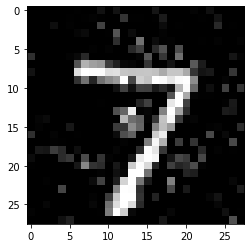

In [17]:
BEST = best + x_test[0]
plt.imshow(BEST.reshape(28,28),cmap='gray')
plt.show()

In [13]:
BEST_X

array([ 0.00000000e+00,  1.12291523e-02,  4.22988203e-02,  2.12128627e-06,
        8.56197183e-03,  1.33234895e-04,  0.00000000e+00,  1.67651070e-03,
        1.13954045e-03,  8.88149397e-02,  0.00000000e+00,  0.00000000e+00,
        2.05403298e-01,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.11169477e-02,  6.92583745e-05,  5.46083869e-02,
        1.93278949e-01, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        8.35477324e-09,  0.00000000e+00,  3.72101798e-04,  1.86307333e-01,
        3.62133804e-03,  2.64553382e-04,  0.00000000e+00,  1.34234452e-06,
        0.00000000e+00,  0.00000000e+00,  7.61389463e-07,  0.00000000e+00,
        0.00000000e+00,  6.35557081e-02,  2.56904145e-05,  0.00000000e+00,
        3.88962725e-03, -0.00000000e+00,  1.26941265e-03,  5.61394451e-02,
        1.45497418e-02,  4.52919618e-03,  1.14664332e-03,  1.35964303e-04,
        2.62873627e-04,  1.64612472e-01,  0.00000000e+00,  9.34312856e-03,
        0.00000000e+00,  

最优值： 0.13100232 扰动程度： 9.958720184761686 代数： 981
最优值： 0.13034652 扰动程度： 10.019872028360068 代数： 982
最优值： 0.12675792 扰动程度： 10.038642353854181 代数： 983


In [11]:
best=np.array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  4.76038584e-03,  0.00000000e+00,
        0.00000000e+00,  6.82002557e-02,  0.00000000e+00,  7.12199673e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  3.49559834e-05,
        8.44994931e-02, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.64327948e-02,  0.00000000e+00,  6.21973893e-02,
        0.00000000e+00,  0.00000000e+00,  7.53864868e-04,  1.45964142e-03,
        2.26740228e-05,  0.00000000e+00,  1.80322107e-05, -0.00000000e+00,
        0.00000000e+00,  7.07831033e-03,  0.00000000e+00,  4.60572886e-03,
        1.21343986e-02,  5.30473886e-03,  5.36895272e-04,  1.35835728e-04,
        2.08333709e-01,  5.77508161e-03,  4.87748483e-03,  1.17956823e-04,
        6.14813901e-03,  1.05645019e-01,  0.00000000e+00,  1.29387617e-03,
        0.00000000e+00,  0.00000000e+00,  6.86631563e-03,  0.00000000e+00,
        7.75819100e-02,  0.00000000e+00,  0.00000000e+00,  5.12996912e-04,
        0.00000000e+00,  4.01056431e-04,  3.88305708e-04,  5.74862095e-02,
        7.22531959e-04,  7.92012954e-03,  0.00000000e+00,  1.85817039e-03,
        2.31689588e-03,  2.55847177e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.69199935e-03,  4.33928525e-02,  1.32989268e-04,  7.75804106e-03,
        0.00000000e+00,  1.74295432e-04, -0.00000000e+00,  0.00000000e+00,
        1.56839695e-01,  2.02611185e-04,  4.21963071e-03,  2.50910274e-05,
        2.49024857e-05,  1.91404070e-04,  0.00000000e+00,  0.00000000e+00,
        1.97982562e-03,  2.57212766e-04,  2.10576408e-02,  3.96045659e-02,
        0.00000000e+00,  0.00000000e+00,  7.47673916e-03,  3.31259068e-01,
        0.00000000e+00,  4.32177269e-02,  0.00000000e+00,  5.03006767e-04,
        0.00000000e+00,  1.18935576e-02,  0.00000000e+00,  0.00000000e+00,
        3.36450498e-03,  0.00000000e+00,  5.17927858e-04,  3.67728603e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.70096166e-04,  0.00000000e+00,  6.58122964e-06,  5.49834804e-04,
        0.00000000e+00,  0.00000000e+00,  1.76848153e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  7.70059250e-04,  1.81018633e-01,
        3.87663893e-05,  0.00000000e+00,  4.42549690e-01,  8.20083485e-04,
        4.74108026e-02,  9.23261260e-03,  1.20425103e-02,  0.00000000e+00,
        0.00000000e+00,  7.13696317e-04,  4.87242675e-03,  0.00000000e+00,
        1.49895188e-02,  1.06765177e-03,  0.00000000e+00,  1.24021955e-02,
        1.68840817e-04,  0.00000000e+00,  0.00000000e+00,  7.57196965e-05,
        6.89250209e-06,  0.00000000e+00,  1.72443305e-04,  0.00000000e+00,
        1.07134024e-02,  4.69306150e-04,  1.54481185e-02,  7.98023247e-05,
        4.42345181e-04,  1.58440441e-01,  2.52713670e-01,  0.00000000e+00,
        1.69398818e-01,  3.23742539e-01,  1.01381455e-02,  2.98242911e-01,
        1.33143348e-03,  3.16601279e-06,  0.00000000e+00,  2.65355698e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.86629884e-01,  1.41131919e-05,  0.00000000e+00,  0.00000000e+00,
        1.48138057e-06,  1.48697191e-02,  3.77982166e-02,  1.61440830e-01,
        0.00000000e+00,  1.27677399e-03,  2.43334465e-03,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  2.29598426e-02,  3.42527787e-01,
        0.00000000e+00,  2.13890128e-01,  0.00000000e+00,  4.34103112e-01,
        0.00000000e+00,  0.00000000e+00,  8.73283913e-07,  2.07754579e-04,
        0.00000000e+00,  1.64606637e-04,  8.38471815e-02,  1.58240248e-02,
        0.00000000e+00,  1.29394207e-03,  0.00000000e+00,  0.00000000e+00,
        1.10517478e-03,  0.00000000e+00,  0.00000000e+00, -3.13548745e-02,
        6.82242595e-04,  0.00000000e+00, -4.88947294e-03, -1.99149820e-02,
        3.12831744e-02,  2.09150072e-02,  0.00000000e+00,  2.04027823e-01,
        3.32553813e-04,  5.96899887e-03,  8.11340843e-02,  0.00000000e+00,
        0.00000000e+00,  3.50433121e-01,  1.08803067e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.01730373e-04,  0.00000000e+00,
        7.23519281e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        9.40814328e-05,  0.00000000e+00, -6.46225849e-03, -6.88497271e-04,
       -1.43084403e-02, -1.36476137e-02, -1.32433006e-01, -6.91860839e-02,
        0.00000000e+00, -1.33582143e-02, -4.32369878e-03,  0.00000000e+00,
       -2.24422883e-02, -1.12404012e-01,  0.00000000e+00,  0.00000000e+00,
       -4.89102815e-05,  2.13008034e-06,  7.80608559e-02,  9.42687896e-02,
        0.00000000e+00,  0.00000000e+00,  2.11304588e-01,  0.00000000e+00,
        2.35452338e-03, -0.00000000e+00,  1.20153853e-03,  0.00000000e+00,
       -0.00000000e+00,  2.23564286e-04, -6.71025368e-02,  0.00000000e+00,
       -1.38527583e-01,  1.00519331e-03, -9.63520003e-02, -2.84561866e-01,
        1.47091283e-04, -6.02109668e-01, -1.87835315e-01, -2.37187850e-01,
        1.78577652e-03, -2.18621634e-03, -6.43836151e-04, -1.62923007e-02,
       -2.42764888e-03, -1.15223969e-03,  6.23516617e-03,  0.00000000e+00,
        0.00000000e+00,  1.93469619e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.05453516e-05,  2.04216325e-03,  0.00000000e+00,
        0.00000000e+00,  2.30788436e-05,  1.02042025e-04,  1.71732592e-05,
        0.00000000e+00,  8.22908251e-04,  5.57460555e-07, -4.54392973e-04,
       -6.51951877e-03,  7.78291187e-03, -1.05223600e-02, -2.03025407e-02,
       -1.67528742e-01, -6.44224601e-02,  2.08272178e-03, -2.15164476e-01,
       -1.77883331e-02,  0.00000000e+00,  6.37390133e-03,  5.58836964e-02,
        8.82869332e-04,  2.46201290e-01,  0.00000000e+00,  2.01600101e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  2.44760594e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  9.68216795e-07,
        0.00000000e+00,  0.00000000e+00,  2.12707943e-05,  2.56587032e-04,
        9.98374561e-04,  2.97194954e-04, -3.24514964e-04,  0.00000000e+00,
       -1.58783577e-01, -5.44197557e-02,  4.10056731e-03,  6.26376207e-03,
        0.00000000e+00,  1.09999028e-03,  5.93526071e-03,  0.00000000e+00,
        1.61429097e-05,  0.00000000e+00,  0.00000000e+00,  2.28869816e-04,
        3.66817094e-06,  0.00000000e+00,  0.00000000e+00,  6.21124743e-07,
        6.23502822e-05,  4.31239488e-03,  0.00000000e+00,  0.00000000e+00,
        2.34843343e-03,  5.60086712e-03,  1.41249375e-01,  2.50403945e-01,
        1.78207262e-05, -8.38759414e-02, -1.00819218e-02, -6.36796542e-04,
       -6.50309894e-02,  4.99211624e-04,  0.00000000e+00,  1.25167753e-03,
        0.00000000e+00,  9.15604806e-03,  1.01051897e-01,  0.00000000e+00,
        0.00000000e+00,  8.45286705e-06,  0.00000000e+00,  1.01173525e-03,
        3.87022620e-04,  4.65424031e-04, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.57234175e-03,  0.00000000e+00,  3.10805499e-01,
        3.97448260e-01,  9.27145136e-01,  1.48570123e-02,  2.71618460e-02,
        0.00000000e+00, -3.65085979e-06,  8.35400690e-04, -2.94565673e-01,
        0.00000000e+00,  4.81915878e-04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.05435928e-01,  8.99467445e-02,  1.99675447e-03,
        0.00000000e+00,  2.32784537e-02,  3.90399172e-02,  1.48818708e-03,
        2.37485298e-04,  0.00000000e+00,  2.94813825e-05,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.76995357e-04,  3.82697604e-03,
        7.16419250e-01,  4.29518500e-01,  3.84110130e-01,  1.95084790e-02,
       -1.09097665e-02, -2.15455569e-01, -2.99402327e-02, -5.43061974e-03,
        7.87890513e-03,  2.02819406e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.04130943e-04,  0.00000000e+00,  2.10890583e-03,
       -0.00000000e+00,  1.18556132e-02,  0.00000000e+00,  9.84562637e-04,
        0.00000000e+00,  9.16183536e-02,  3.37455339e-07,  5.03916417e-05,
        0.00000000e+00,  2.82762987e-03,  0.00000000e+00,  2.33463174e-01,
        2.06543947e-01,  5.50061029e-01,  3.99601058e-01,  4.78364094e-04,
        0.00000000e+00, -2.51771801e-01, -1.23819208e-01, -1.88981422e-02,
        2.04121215e-04,  0.00000000e+00,  1.02288909e-03,  9.70520365e-03,
        1.77859300e-02,  0.00000000e+00,  0.00000000e+00,  1.68078106e-01,
        1.86028317e-01, -0.00000000e+00,  0.00000000e+00,  1.94360085e-02,
        0.00000000e+00,  0.00000000e+00,  5.62211981e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.16147533e-04,  4.92396190e-02,
        3.07015029e-01,  3.83315649e-01,  5.92350010e-03, -3.20902236e-02,
        0.00000000e+00, -5.28785019e-02, -2.08987147e-01,  1.17061284e-03,
        0.00000000e+00,  8.53187560e-04,  1.84099483e-03,  2.83459591e-01,
        3.02580947e-03,  3.53290279e-02,  0.00000000e+00,  0.00000000e+00,
        9.75291496e-04,  0.00000000e+00,  0.00000000e+00,  9.02482807e-03,
        3.93041658e-03, -0.00000000e+00,  0.00000000e+00,  1.34915742e-04,
        0.00000000e+00,  3.19675169e-03,  7.60183430e-04,  0.00000000e+00,
        1.40978453e-02,  0.00000000e+00,  0.00000000e+00,  2.72785110e-04,
       -3.01686298e-02, -1.97445199e-02,  2.41946099e-06,  2.30499423e-01,
        4.11471067e-05,  2.07869529e-01,  7.70254454e-04,  0.00000000e+00,
        0.00000000e+00,  1.21858796e-04,  2.81103110e-01,  0.00000000e+00,
        1.97184557e-03,  9.41364039e-02,  8.33279089e-02,  2.40208112e-01,
        1.66710069e-01,  0.00000000e+00,  5.70312417e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.96189669e-02,
        0.00000000e+00,  0.00000000e+00, -1.20964683e-01,  0.00000000e+00,
       -4.35442258e-02, -3.05038998e-04,  9.31150853e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.60961920e-01,  0.00000000e+00,
        1.36877237e-02,  0.00000000e+00,  6.33905556e-03,  2.63241045e-04,
        4.36596943e-02,  0.00000000e+00,  0.00000000e+00,  3.81131879e-03,
        1.71516502e-01,  2.18024259e-01,  0.00000000e+00,  2.94226972e-01,
        0.00000000e+00,  2.02817554e-01,  1.52801428e-02,  2.93462859e-05,
        5.93718379e-12,  1.15223056e-02,  5.26052848e-02, -3.04116003e-03,
        3.12401894e-01,  0.00000000e+00,  8.82410228e-02,  2.78539242e-01,
        2.28451036e-01,  6.83198515e-05,  2.80006651e-01,  3.09035361e-04,
        0.00000000e+00,  0.00000000e+00,  2.07633357e-04,  0.00000000e+00,
        6.39129908e-03,  4.86045435e-04,  0.00000000e+00,  6.56373063e-04,
        2.38550972e-04,  0.00000000e+00,  9.16345178e-02,  5.25769433e-01,
        1.99473512e-01,  1.76244113e-01,  0.00000000e+00,  9.60727223e-02,
        3.07389822e-03,  0.00000000e+00, -4.67742065e-03, -8.91355719e-03,
        1.01853484e-02,  0.00000000e+00,  2.46068899e-01,  1.47460543e-01,
        1.76770310e-01,  2.99705967e-01,  1.75898109e-02,  2.40511755e-05,
        0.00000000e+00,  5.89462293e-04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.02908489e-04,  6.35598826e-04,
        0.00000000e+00,  4.84376723e-04,  0.00000000e+00,  0.00000000e+00,
        1.28313073e-03,  1.21746093e-02,  0.00000000e+00,  6.46619351e-02,
       -1.21869481e-01, -3.10838449e-04,  0.00000000e+00,  1.39185118e-01,
        0.00000000e+00,  7.77793765e-03,  2.40202706e-06,  1.10556731e-03,
        1.46949051e-01,  1.13268563e-01,  2.59369811e-04,  7.34392150e-05,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.15006420e-04,  1.95070487e-05,  1.01290442e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        4.31870043e-02,  2.58652399e-01,  4.59971809e-03,  1.46835432e-03,
       -5.26680437e-02,  0.00000000e+00,  9.63802121e-03,  9.59615760e-02,
        5.75404354e-04,  0.00000000e+00,  5.00926793e-01,  0.00000000e+00,
        0.00000000e+00,  9.77115278e-05,  0.00000000e+00,  0.00000000e+00,
        2.62217726e-06,  0.00000000e+00,  2.90260832e-02,  7.32927748e-04,
        1.62484485e-03,  1.35929449e-03,  8.33810984e-04, -0.00000000e+00,
        2.73257458e-01,  2.29026498e-05,  3.37185083e-05,  2.37015610e-04,
        2.19059330e-03,  0.00000000e+00,  0.00000000e+00,  1.20035861e-03,
       -6.69071320e-04, -1.07655416e-02, -2.18429766e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.87599325e-01,  2.36604718e-03,
        9.46708929e-02,  0.00000000e+00,  4.41745318e-05,  2.57119763e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.17045710e-01,
        8.71465390e-05,  2.97000271e-03,  0.00000000e+00,  3.79754328e-05,
        0.00000000e+00,  1.65771706e-04,  5.99032760e-04,  0.00000000e+00,
        1.32166514e-02,  0.00000000e+00,  7.14699139e-04, -1.62127939e-01,
       -3.75337165e-04,  2.74685675e-03,  4.93121778e-03,  0.00000000e+00,
        1.36622590e-01,  0.00000000e+00,  0.00000000e+00,  2.90480160e-05,
        0.00000000e+00,  3.82851676e-05,  8.31289672e-04,  2.40448144e-02,
        7.66931269e-02,  0.00000000e+00,  7.66086438e-05,  0.00000000e+00,
        0.00000000e+00,  9.53920051e-06,  2.34849239e-02,  0.00000000e+00,
        3.69814464e-03,  0.00000000e+00,  0.00000000e+00,  6.81916448e-04,
        2.91354461e-02,  0.00000000e+00, -2.91299380e-02, -1.31401107e-01,
       -1.55792096e-03, -1.10724707e-04,  7.42731867e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.68988650e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.87049012e-03,
        2.82178660e-02,  3.56968327e-03,  5.11048916e-05,  0.00000000e+00,
        1.26025762e-02,  0.00000000e+00,  7.48172769e-06,  0.00000000e+00,
        0.00000000e+00,  3.67891995e-04,  0.00000000e+00,  0.00000000e+00,
        3.08691433e-04,  3.97997067e-03,  1.27015249e-02,  7.49102457e-05,
        0.00000000e+00, -3.22871959e-02,  0.00000000e+00,  2.82811418e-05,
        0.00000000e+00,  0.00000000e+00,  3.10447409e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  5.53797676e-04,  0.00000000e+00,
        0.00000000e+00,  6.38662103e-02,  0.00000000e+00,  6.54348271e-03,
        1.13325987e-03,  1.24035415e-03,  4.67837810e-04,  2.03943430e-03,
        6.29923586e-02,  1.32567628e-01,  0.00000000e+00,  0.00000000e+00,
        1.29963626e-03,  3.87099499e-04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.73667129e-04,  2.05571516e-03,  0.00000000e+00,
        0.00000000e+00,  9.12226002e-02,  1.45153964e-03,  0.00000000e+00,
        9.58788290e-05,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.36854308e-05,  1.85566459e-05,  3.12454236e-01,  1.54707425e-07])

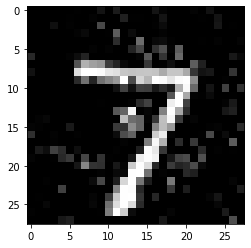

In [16]:
BEST = BEST_X + x_test[0]
plt.imshow(BEST.reshape(28,28),cmap='gray')
plt.show()

In [23]:
result=model.predict(BEST_X.reshape(1,784))
result[0]

array([0.03606191, 0.13325453, 0.30351505, 0.14268604, 0.03217717,
       0.18159828, 0.06348677, 0.01640903, 0.07245255, 0.01835869],
      dtype=float32)

In [12]:
# test
count = 0
for i in range(784):
    if best[i] != 0:
        count+=1
print(count)

473


In [13]:
# test
count = 0
for i in range(784):
    if best[i] > 0.8:
        count+=1
print(count)

1


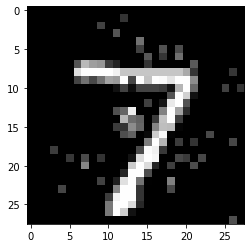

置信度： 0.4757652
[2.0605552e-03 1.1983432e-03 7.9970412e-02 4.1557649e-01 1.8802597e-04
 8.8919709e-03 2.3809307e-05 4.7576520e-01 1.0969363e-02 5.3558866e-03]
扰动程度： 6.7370611369196025


In [17]:
#过滤（低强度）
import copy
x_f = copy.deepcopy(best)
for i in range(784):
    if abs(x_f[i]) < 0.2:
        x_f[i] = 0
f = x_f+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
result=model.predict(f.reshape(1,784))
print("置信度：", result[0][7])
print(result[0])
print("扰动程度：",Dis(x_f))

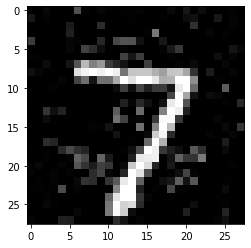

置信度： 0.7140484
[3.5013091e-03 7.0029777e-04 8.5273638e-02 1.8356721e-01 1.1966820e-04
 6.3261571e-03 2.0771509e-05 7.1404839e-01 3.2437495e-03 3.1988441e-03]
扰动程度： 5.399337470712778


In [21]:
#过滤（高强度）
import copy
x_F = copy.deepcopy(BEST_X)
for i in range(784):
    if abs(x_F[i]) > 0.5:
        x_F[i] = 0
F = x_F+x_test[0]
plt.imshow(F.reshape(28,28),cmap='gray')
plt.show()
result=model.predict(F.reshape(1,784))
print("置信度：", result[0][7])
print(result[0])
print("扰动程度：",Dis(x_F))

迭代: 1
置信度： 0.79081285


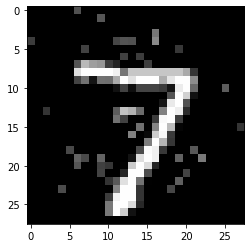

迭代: 2
置信度： 0.78750575


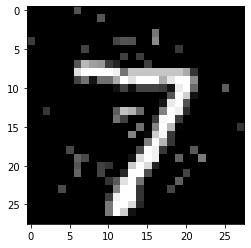

迭代: 3
置信度： 0.7869196


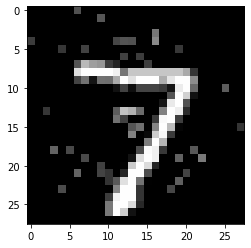

迭代: 4
置信度： 0.7822701


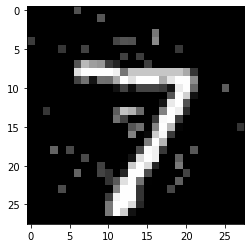

迭代: 5
置信度： 0.78187114


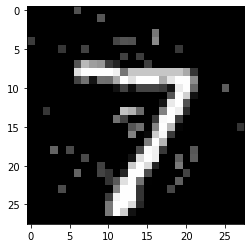

迭代: 6
置信度： 0.777245


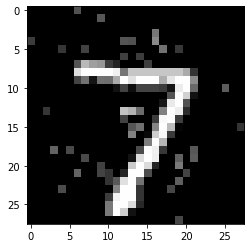

迭代: 7
置信度： 0.7769792


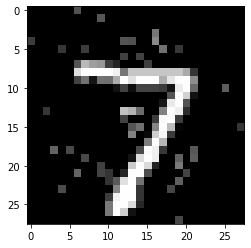

迭代: 8
置信度： 0.77427053


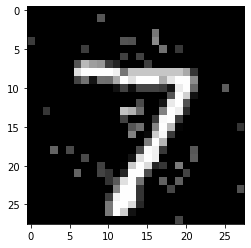

迭代: 9
置信度： 0.7742648


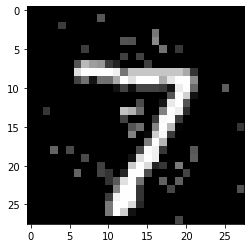

迭代: 10
置信度： 0.77287626


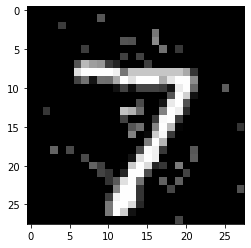

迭代: 11
置信度： 0.7688211


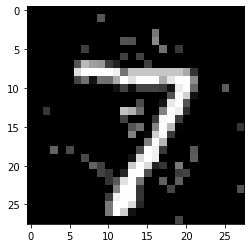

迭代: 12
置信度： 0.76710916


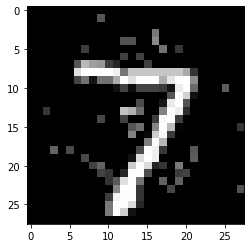

迭代: 13
置信度： 0.76175636


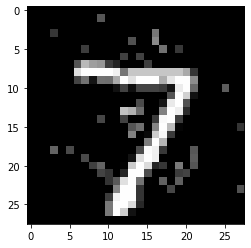

迭代: 14
置信度： 0.754947


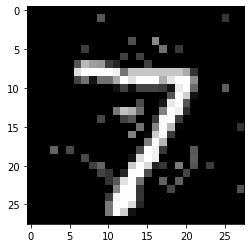

迭代: 15
置信度： 0.73712313


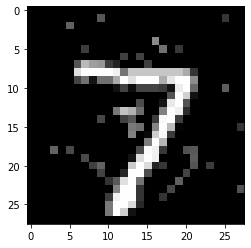

迭代: 16
置信度： 0.73679423


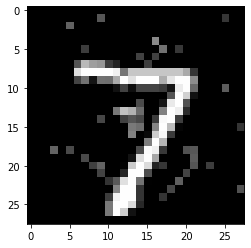

迭代: 17
置信度： 0.7302526


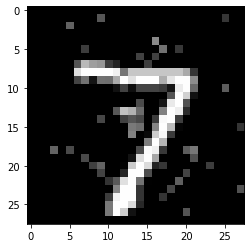

迭代: 18
置信度： 0.7288987


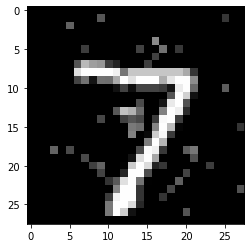

迭代: 19
置信度： 0.72669345


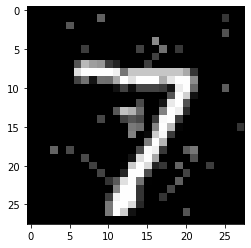

迭代: 20
置信度： 0.7041881


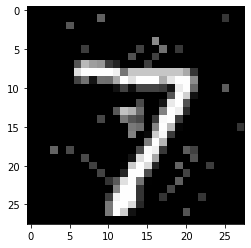

迭代: 21
置信度： 0.69990194


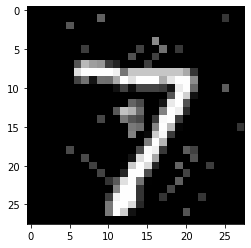

迭代: 22
置信度： 0.69171655


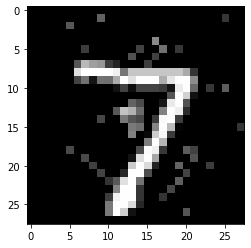

迭代: 23
置信度： 0.69031096


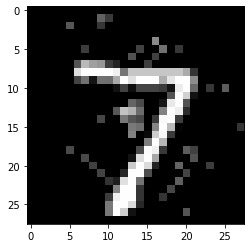

迭代: 24
置信度： 0.6852583


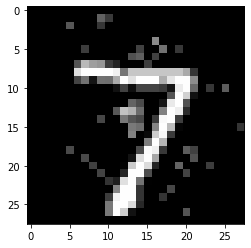

迭代: 25
置信度： 0.6840442


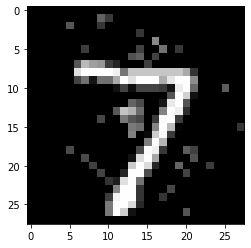

迭代: 26
置信度： 0.672793


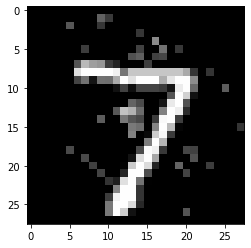

迭代: 27
置信度： 0.6632727


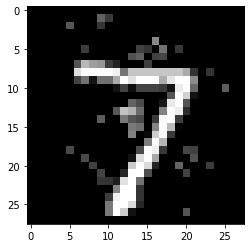

迭代: 28
置信度： 0.6593912


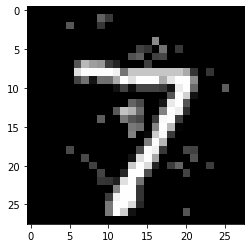

迭代: 29
置信度： 0.65689915


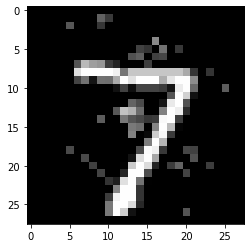

迭代: 30
置信度： 0.642851


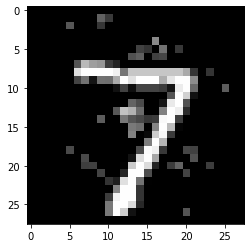

迭代: 31
置信度： 0.6423891


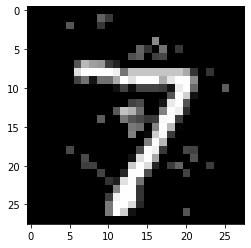

迭代: 32
置信度： 0.6416772


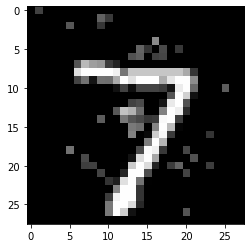

迭代: 33
置信度： 0.6382753


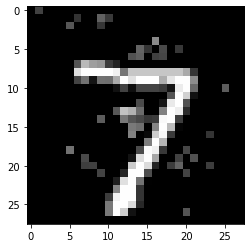

迭代: 34
置信度： 0.6347022


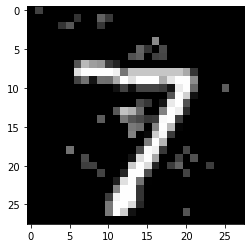

迭代: 35
置信度： 0.6346574


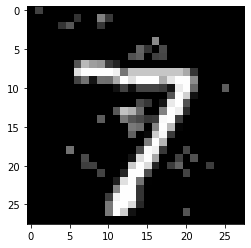

迭代: 36
置信度： 0.6339686


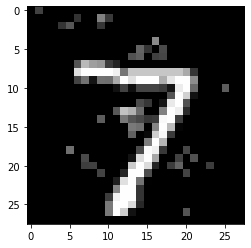

迭代: 37
置信度： 0.63303316


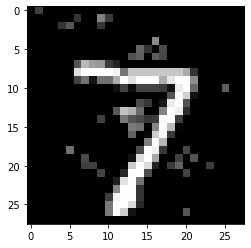

迭代: 38
置信度： 0.6291769


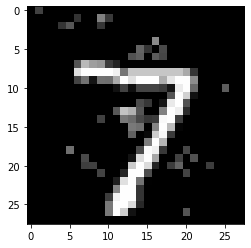

迭代: 39
置信度： 0.6288673


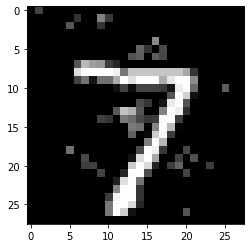

迭代: 40
置信度： 0.6225137


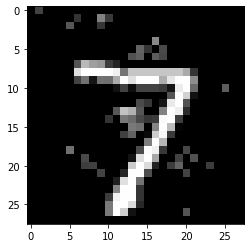

迭代: 41
置信度： 0.6176364


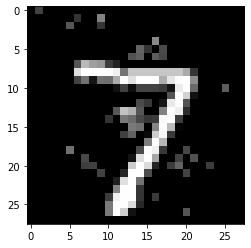

迭代: 42
置信度： 0.61705863


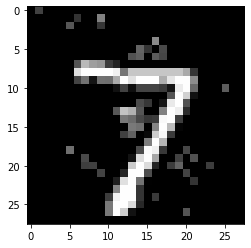

迭代: 43
置信度： 0.611814


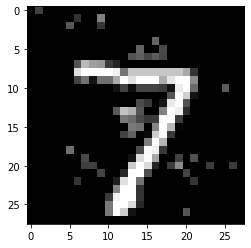

迭代: 44
置信度： 0.6064441


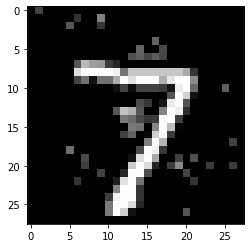

迭代: 45
置信度： 0.5942284


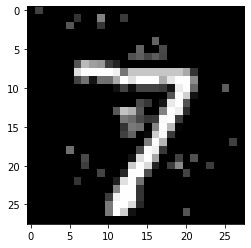

迭代失败


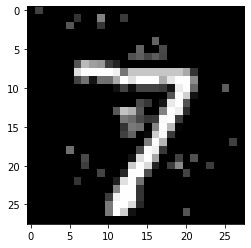

最终置信度： 0.5942284
最终扰动程度： 5.808045297534582
[1.0967220e-03 9.6672133e-04 4.5148227e-02 3.4004280e-01 1.6902824e-04
 4.2748246e-03 1.2764148e-05 5.9422839e-01 6.3656499e-03 7.6948670e-03]


In [24]:
# 改变坐标减小置信度（过滤0.2）
import copy
x_t = copy.deepcopy(x_f)
count = 0
for t in range(80):
    x_f1 = copy.deepcopy(x_t)
    con = 0
    while con < 1000:
        for i in range(784):
            if x_f1[i] > 0:
                x= random.randint(0,10000)/10000
                if x <= 0.1:
                    x_z = x_f1[i]
                    y = random.randint(0,783)
                    f_y = x_f1[y]+x_test[0][i]
                    f_i = x_f1[i]+x_test[0][y]
                    if  (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                        while (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                            y = random.randint(0,783)
                            f_y = x_f1[y]+x_test[0][i]
                            f_i = x_f1[i]+x_test[0][y]
                    x_f1[i] = x_f1[y]
                    x_f1[y] = x_z
        #print(Func(x_f1))
        con += 1
        if Func(x_f1) < Func(x_t):
            x_t = x_f1
            count += 1
            print("迭代:",count)
            print("置信度：",Func(x_t))
            f1 = x_t+x_test[0]
            plt.imshow(f1.reshape(28,28),cmap='gray')
            plt.show()
            break
        x_f1 = copy.deepcopy(x_t)
    if con == 1000:
        print("迭代失败")
        break
f = x_t+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
res=model.predict(f.reshape(1,784))
print("最终置信度：", res[0][7])
print("最终扰动程度：", Dis(x_t))
print(res[0])

迭代失败


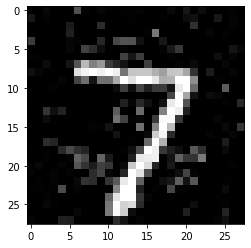

最终置信度： 0.7140484
最终扰动程度： 5.399337470712778
[3.5013091e-03 7.0029777e-04 8.5273638e-02 1.8356721e-01 1.1966820e-04
 6.3261571e-03 2.0771509e-05 7.1404839e-01 3.2437495e-03 3.1988441e-03]


In [22]:
# 改变坐标减小置信度（过滤0.5）
import copy
x_t = copy.deepcopy(x_F)
count = 0
for t in range(80):
    x_f1 = copy.deepcopy(x_t)
    con = 0
    while con < 1000:
        for i in range(784):
            if x_f1[i] > 0:
                x= random.randint(0,10000)/10000
                if x <= 0.1:
                    x_z = x_f1[i]
                    y = random.randint(0,783)
                    f_y = x_f1[y]+x_test[0][i]
                    f_i = x_f1[i]+x_test[0][y]
                    if  (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                        while (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                            y = random.randint(0,783)
                            f_y = x_f1[y]+x_test[0][i]
                            f_i = x_f1[i]+x_test[0][y]
                    x_f1[i] = x_f1[y]
                    x_f1[y] = x_z
        #print(Func(x_f1))
        con += 1
        if Func(x_f1) < Func(x_t):
            x_t = x_f1
            count += 1
            print("迭代:",count)
            print("置信度：",Func(x_t))
            f1 = x_t+x_test[0]
            plt.imshow(f1.reshape(28,28),cmap='gray')
            plt.show()
            break
        x_f1 = copy.deepcopy(x_t)
    if con == 1000:
        print("迭代失败")
        break
f = x_t+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
res=model.predict(f.reshape(1,784))
print("最终置信度：", res[0][7])
print("最终扰动程度：", Dis(x_t))
print(res[0])

迭代失败


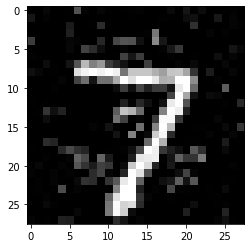

最终置信度： 0.39767227
最终扰动程度： 7.0038201815486
[3.7777259e-03 1.0443135e-03 1.1682559e-01 4.5660120e-01 1.5665211e-04
 1.2439688e-02 3.2627453e-05 3.9767227e-01 7.4698036e-03 3.9801179e-03]


In [11]:
# 改变坐标减小置信度
import copy
x_t = copy.deepcopy(BEST_X)
count = 0
for t in range(80):
    x_f1 = copy.deepcopy(x_t)
    con = 0
    while con < 1000:
        for i in range(784):
            if x_f1[i] > 0:
                x= random.randint(0,10000)/10000
                if x <= 0.1:
                    x_z = x_f1[i]
                    y = random.randint(0,783)
                    f_y = x_f1[y]+x_test[0][i]
                    f_i = x_f1[i]+x_test[0][y]
                    if  (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                        while (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                            y = random.randint(0,783)
                            f_y = x_f1[y]+x_test[0][i]
                            f_i = x_f1[i]+x_test[0][y]
                    x_f1[i] = x_f1[y]
                    x_f1[y] = x_z
        #print(Func(x_f1))
        con += 1
        if Func(x_f1) < Func(x_t):
            x_t = x_f1
            count += 1
            print("迭代:",count)
            print("置信度：",Func(x_t))
            f1 = x_t+x_test[0]
            plt.imshow(f1.reshape(28,28),cmap='gray')
            plt.show()
            break
        x_f1 = copy.deepcopy(x_t)
    if con == 1000:
        print("迭代失败")
        break
f = x_t+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
res=model.predict(f.reshape(1,784))
print("最终置信度：", res[0][7])
print("最终扰动程度：", Dis(x_t))
print(res[0])